In [ ]:
#Import necessary libraries:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


In [ ]:
# prompt: df should read csv directly from yfinance website of live stock data of TATAMOTORS
#Load dataset
import yfinance as yf

df = yf.download('TATAMOTORS.NS')


[*********************100%%**********************]  1 of 1 completed


In [ ]:
#Display the first few rows of the dataframe:
print(df.head())


                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
1991-01-02  20.959597  21.857864  20.959597  21.857864  15.690217       0
1991-01-03  20.959597  21.857864  20.959597  21.857864  15.690217       0
1991-01-04  21.857864  21.857864  21.857864  21.857864  15.690217       0
1991-01-07  20.360750  21.259020  20.061329  21.109308  15.152887       0
1991-01-08  21.109308  21.109308  21.109308  21.109308  15.152887       0


In [ ]:
#Preprocessing
#Handling missing values

df = df.dropna()


In [ ]:
# Normalize the dataset

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1,1))

In [ ]:
#Create trainign dataset

training_data_len = int(np.ceil(len(scaled_data) * 0.8))
train_data = scaled_data[0:int(training_data_len), :]

In [ ]:
#Create teh dataset for features and labels

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
#Model Building

# define the model

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Compile the model

model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
#Train the model

model.fit(x_train, y_train, batch_size=1, epochs=1)


6731/6731 ━━━━━━━━━━━━━━━━━━━━ 182s 27ms/step - loss: 4.4287e-04


In [ ]:
# Model Eveluation


#create testing dataset

test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = df['Close'][training_data_len:].values

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
#get the predictions

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [ ]:
# Evaluate the model

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(f'RMSE: {rmse}')

RMSE: 332.7978687734448


<ipython-input-14-cde6990296d1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


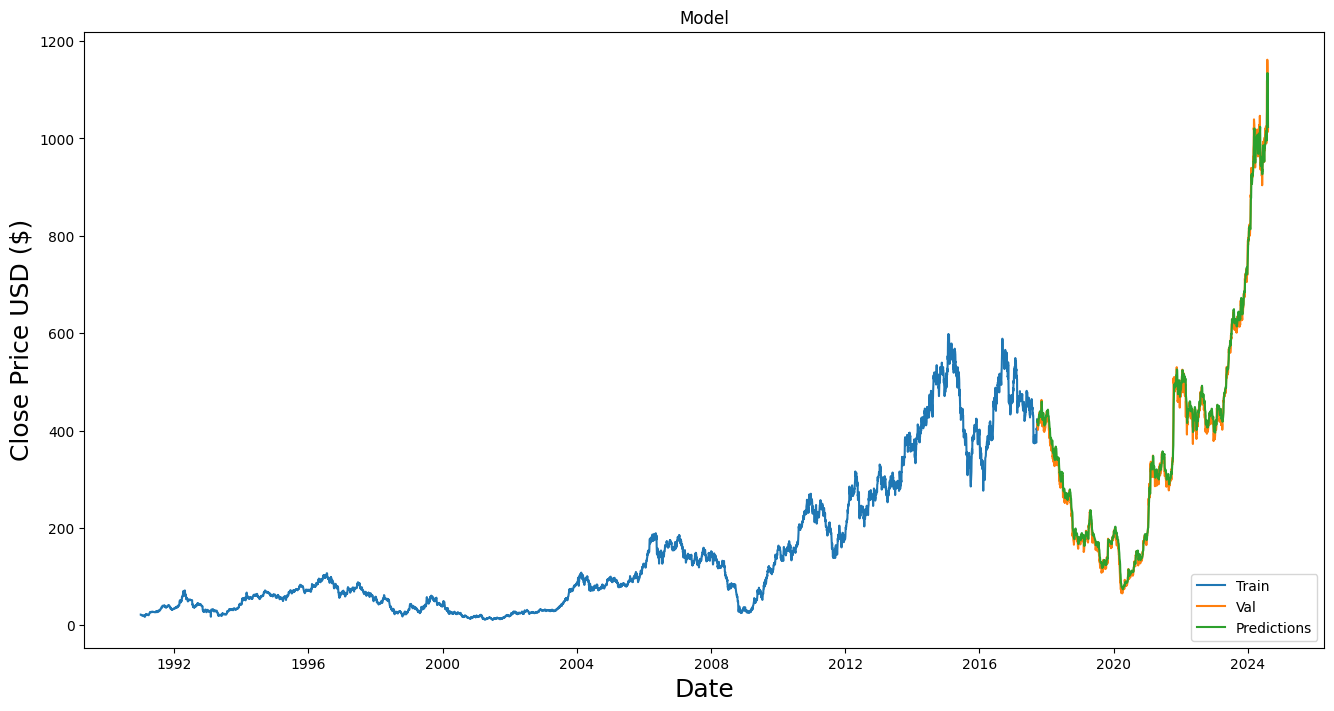

In [ ]:
# Plot the results


train = df[:training_data_len]
valid = df[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()
